# Extractive Summ with CNN

## Modules Required

In [ ]:
!pip install rouge-score
!pip install rouge

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=12d78064d3fd35aa3ead05cf6e9411c29625ee1e49605f6872ac010e1cb06072
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install transformers
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.6 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.insert(0, '../')
import torch
import nltk
nltk.download('punkt')
from rouge_score import rouge_scorer
from sklearn.preprocessing import MinMaxScaler
from rouge import Rouge
import math
import pandas as pd
import numpy as np
from tqdm import tqdm

from transformers import BertTokenizer, TFBertModel
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D,concatenate,Lambda, AveragePooling2D
from keras.layers.convolutional import Conv2D
from keras import regularizers
from keras.optimizers import Adadelta

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!git clone https://github.com/yasithdev/capsnet.git

Cloning into 'capsnet'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 444 (delta 3), reused 0 (delta 0), pack-reused 434
Receiving objects: 100% (444/444), 104.92 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (280/280), done.


In [ ]:
cd capsnet

/content/capsnet


In [ ]:
from capsnet import nn, layers
from capsnet.layers import ConvCaps2D, DenseCaps

## Getting the data

In [ ]:
train=pd.read_csv("/content/training.csv")
valid=pd.read_csv("/content/validation.csv")
test=pd.read_csv("/content/test.csv")

In [ ]:
train.dropna(inplace=True)
valid.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
train_source = train['article'].values.tolist()
train_summary = train['highlights'].values.tolist()
print("train file read successfully")
valid_source = valid['article'].values.tolist()
valid_summary = valid['highlights'].values.tolist()
print("valid file read successfully")
data_source = train_source+valid_source
data_summary = train_summary+valid_summary

train file read successfully
valid file read successfully


## Calculating Saliency score for each sentence with its summary

In [ ]:
def saliency_score(doc, summary, alpha=0.5):
  # takes in two inputs and returns the saliency score
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
  scores = scorer.score(doc, summary)
  R1 = scores['rouge1'][2]
  R2 = scores['rouge2'][2]

  return alpha * R1 + (1 - alpha) * R2

def split_to_sentences(para):
    sents = nltk.sent_tokenize(para)   # returns list of sentences from para
    return sents

In [ ]:
input_data = [[],[],[],[],[],[]]  # [docid, sentid, sentences, length of sentence, length of summary, saliency scores]
total_sentences_doc = []
total_sentences_summary = []
for i in tqdm(range(len(data_source))):
  splitted_doc = split_to_sentences(data_source[i])
  total_sentences_doc.append(len(splitted_doc))
  doc_sents = []
  for ind in range(len(splitted_doc)):
    if len(splitted_doc[ind].split())>5:
      doc_sents.append(splitted_doc[ind])
  summary = data_summary[i]
  total_sentences_summary.append(len(split_to_sentences(summary)))
  saliency_list = []
  for sent in doc_sents:
    saliency_list.append(saliency_score(sent, summary))
  saliency_list = np.array(saliency_list)
  mms = MinMaxScaler()
  if len(saliency_list)>0:  # to avoide this error: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
    scaled_saliency_list = mms.fit_transform(saliency_list.reshape(-1,1))
    for j in range(len(doc_sents)):
      len_sent = len(doc_sents[j].split())
      input_data[0].append(i)
      input_data[1].append(j)
      input_data[2].append(doc_sents[j])
      input_data[3].append(len_sent)
      input_data[4].append(len(split_to_sentences(summary)))
      input_data[5].append(scaled_saliency_list[j][0])

100%|██████████| 29/29 [00:01<00:00, 23.02it/s]


In [ ]:
avg_sent_per_doc = sum(total_sentences_doc)/len(data_source)
avg_sent_per_sum = sum(total_sentences_summary)/len(data_summary)
longest_sent = max(total_sentences_doc)

print('Average sentences per doc: ',avg_sent_per_doc)
print('Average sentences per summary: ',avg_sent_per_sum)
print('Longest sentence in doc:', longest_sent)

Average sentences per doc:  36.827586206896555
Average sentences per summary:  3.9310344827586206
Longest sentence in doc: 83


In [ ]:
df = pd.DataFrame({'doc_id':input_data[0],'sent_id':input_data[1],'Sentence':input_data[2],'Sentence Length':input_data[3], 'Summary Length':input_data[4], 'Saliency Score':input_data[5]})

df.head()

,doc_id,sent_id,Sentence,Sentence Length,Summary Length,Saliency Score
0,0,0,"14:11 EST, 25 October 2013 .",6,3,0.000000
1,0,1,"15:36 EST, 25 October 2013 .",6,3,0.000000
2,0,2,The bishop of the Fargo Catholic Diocese in No...,34,3,0.787966
3,0,3,The state Health Department has issued an advi...,19,3,0.173988
4,0,4,Bishop John Folda (pictured) of the Fargo Cath...,30,3,1.000000


In [ ]:
df.dtypes

doc_id               int64
sent_id              int64
Sentence            object
Sentence Length      int64
Summary Length       int64
Saliency Score     float64
dtype: object

In [ ]:
df.shape

(937, 6)

In [ ]:
df.to_csv('saliency_sentences.csv')

## Generate word embeddings for each sentence in doc

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')   # distilbert-base-uncased
enc_model = TFBertModel.from_pretrained("bert-base-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Removing sentences with more than 76 tokens and storing in df - saliency_sentences_76

In [ ]:
saliency_sentences = pd.read_csv('saliency_sentences.csv',  usecols=['Sentence','Saliency Score'])

saliency_sentences.head()

,Sentence,Saliency Score
0,"14:11 EST, 25 October 2013 .",0.000000
1,"15:36 EST, 25 October 2013 .",0.000000
2,The bishop of the Fargo Catholic Diocese in No...,0.787966
3,The state Health Department has issued an advi...,0.173988
4,Bishop John Folda (pictured) of the Fargo Cath...,1.000000


In [ ]:
input_data = saliency_sentences.to_numpy().transpose()

sentences = input_data[0]

In [ ]:
input_data.shape

(2, 937)

In [ ]:
import numpy as np
max_len = 0
count76=0
summ=0
out_range=[]
for i in tqdm(range(len(sentences))):
  encoded_text = tokenizer(sentences[i], return_tensors='tf')
  l = len(np.array(encoded_text['input_ids'])[0])
  if l>76:
    count76+=1
    out_range.append(i)
    continue
  summ+=l
  if l>max_len:
    max_len=l

avg_token_size = summ/len(sentences)
print(max_len, avg_token_size, count76)

100%|██████████| 937/937 [00:01<00:00, 816.59it/s]

72 29.056563500533617 10


In [ ]:
input_data_76 = np.delete(input_data,out_range, axis=1)   # add in prev loop with an if statement that if l>100 -> delete that row

input_data_76.shape

(2, 927)

In [ ]:
saliency_sentences_76 = pd.DataFrame(data = input_data_76.transpose(), columns = ['Sentence', 'Saliency Score'])

saliency_sentences_76.head()

,Sentence,Saliency Score
0,"14:11 EST, 25 October 2013 .",0.0
1,"15:36 EST, 25 October 2013 .",0.0
2,The bishop of the Fargo Catholic Diocese in No...,0.787966
3,The state Health Department has issued an advi...,0.173988
4,Bishop John Folda (pictured) of the Fargo Cath...,1.0


### Generating embedding batchwise

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
train_dataset = Dataset.from_pandas(saliency_sentences_76)

In [ ]:
train_dataset

Dataset({
    features: ['Sentence', 'Saliency Score'],
    num_rows: 927
})

In [ ]:
datasets = DatasetDict()
datasets['train'] = train_dataset
datasets

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Saliency Score'],
        num_rows: 927
    })
})

In [ ]:
result_arr = []

def preprocess_function(examples):
  encoded_sentences = tokenizer(examples['Sentence'], return_tensors='tf', padding='max_length', max_length=76)
  embedded_sentences = enc_model(encoded_sentences)
  result_arr.append(embedded_sentences['last_hidden_state'])
  return embedded_sentences

In [ ]:
tokenized_dataset = datasets.map(preprocess_function, batched=True)  # batch_size=1000 by default

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/927 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Saliency Score', 'last_hidden_state', 'pooler_output'],
        num_rows: 927
    })
})

In [ ]:
len(result_arr), len(result_arr[0]),len(result_arr[0][0]),len(result_arr[0][0][0]),

(1, 927, 76, 768)

In [ ]:
x = np.concatenate(result_arr)

In [ ]:
x.shape

(927, 76, 768)

In [ ]:
#sentences = input_data[0]

In [ ]:
#encoded_sentences = tokenizer(list(sentences), return_tensors='tf', padding='max_length', max_length=76)

In [ ]:
#embedded_sentences = enc_model(encoded_sentences)

In [ ]:
#x = embedded_sentences['last_hidden_state'].numpy()

In [ ]:
#x.shape

In [ ]:
y = np.array(datasets['train']['Saliency Score'])

In [ ]:
y_re = y.astype(np.float32)

In [ ]:
y_re.shape

(927,)

## Modelling

In [ ]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
# # capsule BiLSTM-CNN  for CNNDM

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    inputs = tf.keras.Input(shape=(50, 768, 1))  # x.shape[1]

    conv2d_layer_1 = Conv2D(128, (3,768), padding='valid', activation='relu', strides=1)(inputs)
    conv2d_layer_2 = Conv2D(128, (4,1), padding='valid', activation='relu', strides=1)(conv2d_layer_1)

    input_reshaped = tf.keras.layers.Reshape(target_shape=(conv2d_layer_2.shape[1], conv2d_layer_2.shape[2]*conv2d_layer_2.shape[3]))(conv2d_layer_2)
    gru1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(input_reshaped)
    gru2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(gru1)

    gru_reshaped = tf.keras.layers.Reshape(target_shape=(gru2.shape[1], 1, gru2.shape[2]))(gru2)

    # convert to capsule domain
    conv_caps_2d = ConvCaps2D(filters=16, filter_dims=8, kernel_size=(5,1), strides=(1, 1), name='conv_caps_2d')(gru_reshaped)
    conv_caps_2d = Lambda(nn.squash)(conv_caps_2d)

    # dense layer for dynamic routing
    dense_caps = DenseCaps(caps=2, caps_dims=16, routing_iter=3, name='dense_caps')(conv_caps_2d)
    dense_caps = Lambda(nn.squash)(dense_caps)

    #merged = concatenate([tower1, tower2, tower3, tower4], axis=2)
    merged = Flatten()(dense_caps)

    #drop = Dropout(0.1)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy',
                      optimizer=Adadelta(),
                      metrics=['mean_absolute_error','accuracy'])


In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50, 768, 1)]      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 1, 128)        295040    
                                                                 
 conv2d_23 (Conv2D)          (None, 45, 1, 128)        65664     
                                                                 
 reshape_8 (Reshape)         (None, 45, 128)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 45, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 45, 128)          74496     
 nal)                                                     

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 768, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 1, 128)        295040    
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 1, 128)        65664     
                                                                 
 conv_caps_2d (ConvCaps2D)   (None, 41, 1, 16, 8)      5248      
                                                                 
 lambda_12 (Lambda)          (None, 41, 1, 16, 8)      0         
                                                                 
 dense_caps (DenseCaps)      (None, 10, 16)            839680    
                                                                 
 lambda_13 (Lambda)          (None, 10, 16)            0   

In [ ]:
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    inputs = tf.keras.Input(shape=(76, 768, 1))  # x.shape[1]

    conv2d_layer_1 = Conv2D(64, (3,257), padding='valid', activation='relu', strides=1)(inputs)
    conv2d_layer_2 = Conv2D(128, (9,257), padding='valid', activation='relu', strides=2)(conv2d_layer_1)

    avgpool = AveragePooling2D((2,2))(conv2d_layer_2)

    # convert to capsule domain
    conv_caps_2d = ConvCaps2D(filters=16, filter_dims=8, kernel_size=(5,5), strides=(2, 2), name='conv_caps_2d')(avgpool)
    conv_caps_2d = Lambda(nn.squash)(conv_caps_2d)

    # dense layer for dynamic routing
    dense_caps = DenseCaps(caps=10, caps_dims=16, routing_iter=3, name='dense_caps')(conv_caps_2d)
    dense_caps = Lambda(nn.squash)(dense_caps)

    #merged = concatenate([tower1, tower2, tower3, tower4], axis=2)
    merged = Flatten()(dense_caps)

    #drop = Dropout(0.1)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy',
                      optimizer=Adadelta(),
                      metrics=['mean_absolute_error','accuracy'])



**Without capsule network**

In [ ]:
# Open a strategy scope.

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    inputs = tf.keras.Input(shape=(76, 768, 1))  # x.shape[1]

    conv2d_layer_1 = Conv2D(400, (3,257), padding='valid', activation='relu', strides=1)(inputs)

    avgpool = AveragePooling2D((2,2))(conv2d_layer_1)
    # maxpool = MaxPooling2D(pool_size=(2, 1))(conv2d_layer_1)

    flat = Flatten()(avgpool)

    drop = Dropout(0.1)(flat)
    outputs = Dense(1, activation='sigmoid')(flat)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy',
                      optimizer=Adadelta(),
                      metrics=['mean_absolute_error','accuracy'])





In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 76, 768, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 74, 512, 64)       49408     
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 128, 128)      18948224  
                                                                 
 average_pooling2d (AverageP  (None, 16, 64, 128)      0         
 ooling2D)                                                       
                                                                 
 conv_caps_2d (ConvCaps2D)   (None, 6, 30, 16, 8)      25728     
                                                                 
 lambda (Lambda)             (None, 6, 30, 16, 8)      0         
                                                             

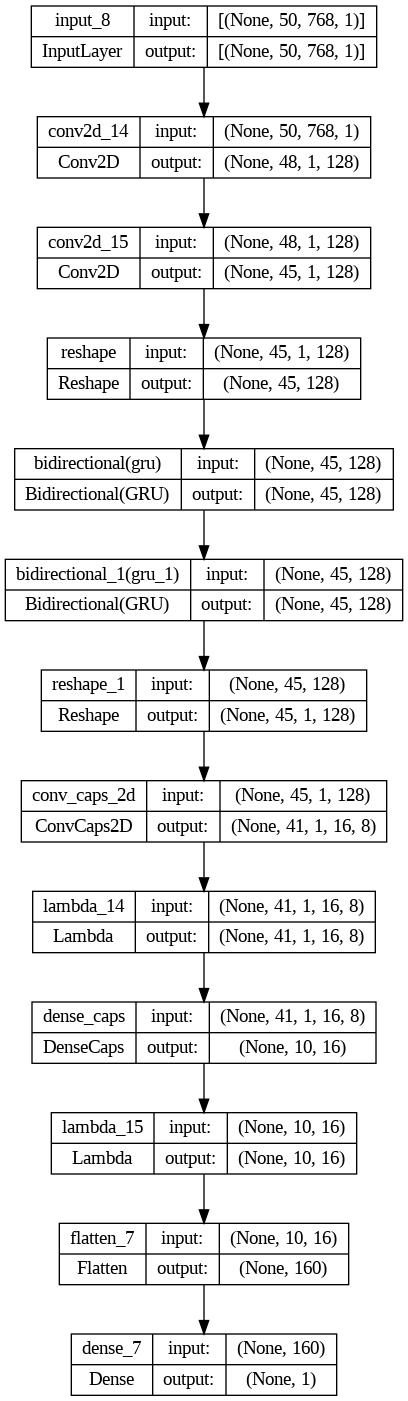

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Training parameters
epochs = 1
batch_size = 32
test_train_ratio = 0.2
val_train_ratio = 0.2

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

In [ ]:
import os

def train(model, x_train, y_train, val_train_ratio=0.2, epochs=100, batch_size=64):
  history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_train_ratio,
                        shuffle=False,
                        verbose=1,
                        callbacks=[early_stop])
  #model.save('/content/my_model')
  return history

In [ ]:
x.shape

(927, 76, 768)

In [ ]:
x_re = x.reshape(x.shape[0], x.shape[1], 768, 1)  # changed from (x_test.shape[0], 1, x_test.shape[1], 768)

In [ ]:
x_re.shape

(927, 76, 768, 1)

In [ ]:
history = train(model, x_re, y_re, val_train_ratio, epochs, batch_size)

24/24 [==============================] - 226s 6s/step - loss: 0.6931 - mean_absolute_error: 0.3053 - accuracy: 0.0607 - val_loss: 0.6931 - val_mean_absolute_error: 0.2964 - val_accuracy: 0.0484


In [ ]:
final_epoch = early_stop.stopped_epoch
if final_epoch==0:  #implies early stopping hasn't occures
  final_epoch=epochs-1

In [ ]:
import matplotlib.pyplot as plt
print("Plotting...")
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(1, final_epoch+2), history.history['val_mean_absolute_error'], 'tab:blue', label="validation MAE")
ax1.plot(range(1, final_epoch+2), history.history['mean_absolute_error'], 'tab:red', label="training MAE")

ax2.plot(range(1, final_epoch+2), history.history['loss'], 'tab:orange', label="loss")
ax2.plot(range(1, final_epoch+2), history.history['val_loss'], 'tab:green', label="validation loss")

ax1.legend()
ax2.legend()

In [ ]:
new_model = tf.keras.models.load_model('/content/my_model')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 76, 768, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 74, 512, 64)       49408     
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 128, 128)      18948224  
                                                                 
 average_pooling2d (AverageP  (None, 16, 64, 128)      0         
 ooling2D)                                                       
                                                                 
 conv_caps_2d (ConvCaps2D)   (None, 6, 30, 16, 8)      25728     
                                                                 
 lambda (Lambda)             (None, 6, 30, 16, 8)      0         
                                                             

In [ ]:
model.save_weights('capsule.h5')

## Testing

In [ ]:
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    inputs = tf.keras.Input(shape=(76, 768, 1))  # x.shape[1]

    conv2d_layer_1 = Conv2D(64, (3,257), padding='valid', activation='relu', strides=1)(inputs)
    conv2d_layer_2 = Conv2D(128, (9,257), padding='valid', activation='relu', strides=2)(conv2d_layer_1)

    avgpool = AveragePooling2D((2,2))(conv2d_layer_2)

    # convert to capsule domain
    conv_caps_2d = ConvCaps2D(filters=16, filter_dims=8, kernel_size=(5,5), strides=(2, 2), name='conv_caps_2d')(avgpool)
    conv_caps_2d = Lambda(nn.squash)(conv_caps_2d)

    # dense layer for dynamic routing
    dense_caps = DenseCaps(caps=10, caps_dims=16, routing_iter=3, name='dense_caps')(conv_caps_2d)
    dense_caps = Lambda(nn.squash)(dense_caps)

    #merged = concatenate([tower1, tower2, tower3, tower4], axis=2)
    merged = Flatten()(dense_caps)

    #drop = Dropout(0.1)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy',
                      optimizer=Adadelta(),
                      metrics=['mean_absolute_error','accuracy'])

In [ ]:
model.load_weights('capsule.h5')

In [ ]:
test_data_source = test['article'].values.tolist()
test_data_summary = test['highlights'].values.tolist()

In [ ]:
k = math.ceil(avg_sent_per_sum)
print('Value of k:',k)

In [ ]:
result_rouge_list = []

for i in range(len(test_data_source)):
  doc = test_data_source[i]
  summary = test_data_summary[i]
  sentences = split_to_sentences(doc)

  # sentences are encoded (padded and truncated to input size of model) and embedded using BERT
  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=76)
  embedded_sentences = enc_model(encoded_sentences)

  # embedded_sentences has two outputs- 'last_hidden_state' and 'pooler_output' (which is like sentence embedding)
  x_test = embedded_sentences['last_hidden_state'].numpy()
  # reshaping to format acceptable by model
  x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1], 768, 1)
  y_pred = model.predict(x_test_re)
  y_pred=y_pred.reshape(y_pred.shape[0],)

  # choosing the top k (k- average of number of sentences per summary during training)
  temp = sorted(y_pred)[-k:]
  sal_index = []
  for ele in temp:
    sal_index.append(list(y_pred).index(ele))
  sal_index_sorted = sorted(sal_index)

  # pred_summary - list of sentences having the top k saliency scores as predicted by the model
  pred_summary = []
  for ind in sal_index_sorted:
    pred_summary.append(sentences[ind])

  # the sentences in pred_summary are joined
  final_pred_summary = ' '.join(pred_summary)

  # Rouge score is calculates between the predicted summary (final_pred_summary) and the reference summary
  rouge = Rouge()
  result_rouge_list.append(rouge.get_scores(summary, final_pred_summary, avg=True))

In [ ]:
agg_rouge_score = {'rouge-1':{'r':0,'p':0,'f':0},'rouge-2':{'r':0,'p':0,'f':0},
                   'rouge-l':{'r':0,'p':0,'f':0}}

for i in range(len(result_rouge_list)):
  for rouge_type in ['rouge-1','rouge-2','rouge-l']:
    for j in ['r','p','f']:
      agg_rouge_score[rouge_type][j]+=(result_rouge_list[i][rouge_type][j]/len(result_rouge_list))

print(agg_rouge_score)

## Updated Evaluation

In [ ]:
!pip install evaluate
!pip install bert_score

from evaluate import load

In [ ]:
test_data_source = test['article'].values.tolist()      # list containing articles of test dataset
test_data_summary = test['highlights'].values.tolist()  # list containing highlights of test dataset

In [ ]:
print(len(test_data_source))
print(len(test_data_summary))

5
5


In [ ]:
import tqdm

In [ ]:
result_rouge_list = []
result_bertscore_list = []

for i in tqdm(range(len(test_data_source))):
  doc = test_data_source[i]
  summary = test_data_summary[i]
  print(doc)
  print('---------------------------------------')
  sentences = split_to_sentences(doc)

  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=76)
  embedded_sentences = enc_model(encoded_sentences)

  # embedded_sentences has two outputs- 'last_hidden_state' and 'pooler_output' (which is like sentence embedding)
  x_test = embedded_sentences['last_hidden_state'].numpy()
  # reshaping to format acceptable by model
  x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1], 768, 1)
  y_pred = model.predict(x_test_re)
  y_pred=y_pred.reshape(y_pred.shape[0],)
  """
  # sentences are encoded (padded and truncated to input size of model) and embedded using BERT
  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=50)
  test_input_ids = encoded_sentences['input_ids']
  test_attention_mask = encoded_sentences['attention_mask']

  y_pred = model.predict([test_input_ids,test_attention_mask])
  y_pred = y_pred.reshape(y_pred.shape[0],)
  """
  temp = sorted(y_pred,reverse=True)   # saliency scores sorted in descending order
  pred_summary = []
  word_limit=75                        # specify word limit to restrict summary length to
  l = 0
  for i in range(len(temp)):           # loopong through all values
    ind = list(y_pred).index(temp[i])        # getting index of saliency score to match to sentence
    if l<word_limit:
      l+=len(sentences[ind].split(' '))
      if l<=word_limit:                # if after adding this sentence, word limit is not exceeded- add it completely
        pred_summary.append([ind,sentences[ind]])  # index added to sort in order later
      else:
        req_len = l-word_limit
        temp_list = sentences[ind].split(' ')[:req_len]
        pred_summary.append([ind,' '.join(temp_list)])  # if after adding this sentence, word limit is exceeded - add till limit is reached

  def Sort(sub_li):
    sub_li.sort(key = lambda x: x[0])
    return sub_li

  pred_summary_index_sorted = Sort(pred_summary)   # sort the sentences according to increasing value of index to retain order
  # the sentences in pred_summary are joined
  pred_summary_sorted = []
  for i in range(len(pred_summary_index_sorted)):
    pred_summary_sorted.append(pred_summary_index_sorted[i][1])

  final_pred_summary = ' '.join(pred_summary_sorted)   # join all sentences in list

  # Rouge score is calculates between the predicted summary (final_pred_summary) and the reference summary
  rouge = Rouge()
  result_rouge_list.append(rouge.get_scores(final_pred_summary, summary, avg=True))  # rouge.get_scores(sys, ref, avg=True)
  bertscore = load("bertscore")
  result_bertscore_list.append(bertscore.compute(predictions=[final_pred_summary], references=[summary], model_type="distilbert-base-uncased"))

TypeError: ignored

In [ ]:
result_rouge_list = []
result_bertscore_list = []

for i in range(len(test_data_source)):
  doc = test_data_source[i]
  summary = test_data_summary[i]
  sentences = split_to_sentences(doc)
  print(doc)
  print('---------------------------------------')

  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=76)
  embedded_sentences = enc_model(encoded_sentences)

  # embedded_sentences has two outputs- 'last_hidden_state' and 'pooler_output' (which is like sentence embedding)
  x_test = embedded_sentences['last_hidden_state'].numpy()
  # reshaping to format acceptable by model
  x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1], 768, 1)
  y_pred = model.predict(x_test_re)
  print(y_pred)
  print('--------------------------')
  y_pred=y_pred.reshape(y_pred.shape[0],)
  print(y_pred)
  print('--------------------------')

  def Sort(sub_li, r):
    sub_li.sort(key = lambda x: x[0], reverse=r) # reverse=True will sort the list descending
    return sub_li

  predictions = []
  for i in range(len(y_pred)):
    predictions.append([y_pred[i], i, sentences[i]])    # appending list of saliency score and its corresponding index and sentence
  print(predictions)
  print('--------------------------')

  sorted_predictions = Sort(predictions,True)            # sorting pairs according to saliency score in descending order; True implies descending order
  print(sorted_predictions)
  print('--------------------------')
  unordered_summary = []
  l = 0
  word_limit = 75                                   # to test for word_limit = 75 & 100 for daily mail
  for i in range(len(sorted_predictions)):          # looping through sentences in order of descending value of saliency score
    ind = sorted_predictions[i][1]
    sent = sorted_predictions[i][2]
    if l<word_limit:
      l+=len(sent.split(' '))
      if l<=word_limit:
        unordered_summary.append([ind,sent])
      else:
        req_len = l-word_limit
        temp_list = sent.split(' ')[:req_len]
        unordered_summary.append([ind,' '.join(temp_list)])  # if after adding this sentence, word limit is exceeded - add till limit is reached
  print(unordered_summary)
  print('--------------------------')

  predicted_summary = Sort(unordered_summary,False)    # sort according to index value; False implies ascending order of index
  print(predicted_summary)
  print('--------------------------')
  temp_summary_list = []
  for i in range(len(predicted_summary)):
    temp_summary_list.append(predicted_summary[i][1])
  final_pred_summary = ' '.join(temp_summary_list)   # join all sentences in list
  temp_final_pred_summary = final_pred_summary.split(' ')[:word_limit]
  final_pred_summary = ' '.join(temp_final_pred_summary)
  print(final_pred_summary)
  print(len(final_pred_summary.split(' ')))

  print('--------------------------')
  print('--------------------------')
  # Rouge score is calculates between the predicted summary (final_pred_summary) and the reference summary
  rouge = Rouge()
  result_rouge_list.append(rouge.get_scores(final_pred_summary, summary, avg=True))  # rouge.get_scores(sys, ref, avg=True)
  bertscore = load("bertscore")
  result_bertscore_list.append(bertscore.compute(predictions=[final_pred_summary], references=[summary], model_type="distilbert-base-uncased"))

Beirut (CNN) -- Syria carried out an airstrike on a refugee camp in northern Lebanon Saturday, killing nine Syrians and wounding nine more, a Lebanese state-run news agency reported. The strike centered on a Syrian refugee camp located near the Syrian border between the towns of Baalbeck and Arsal in the Bekaa Valley, the National News Agency said. The Red Cross took the casualties to Universal Hospital in Baalbek. Saturday's strike was not the first by the Syrian government, which has accused rebels of smuggling arms and supplies across the border. On March 18, two Syrian jets fired three rockets that hit empty buildings near Arsal. At the time, a U.S. State Department spokeswoman called the use of fighter jets to fire rockets into Lebanon a "significant escalation." U.N. commissioner wants to probe into whether Syrian rebels executed soldiers . Also in March, the U.N. Security Council voiced "grave concern over repeated incidents of cross-border fire which caused death and injury amo

In [ ]:
result_rouge_list = []
result_bertscore_list = []

for i in tqdm(range(len(test_data_source))):
  doc = test_data_source[i]
  summary = test_data_summary[i]
  sentences = split_to_sentences(doc)

  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=76)
  embedded_sentences = enc_model(encoded_sentences)

  # embedded_sentences has two outputs- 'last_hidden_state' and 'pooler_output' (which is like sentence embedding)
  x_test = embedded_sentences['last_hidden_state'].numpy()
  # reshaping to format acceptable by model
  x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1], 768, 1)
  y_pred = model.predict(x_test_re)
  print(y_pred)
  print('--------------------------')
  y_pred=y_pred.reshape(y_pred.shape[0],)
  print(y_pred)
  print('--------------------------')
  """
  # sentences are encoded (padded and truncated to input size of model) and embedded using BERT
  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=50)
  test_input_ids = encoded_sentences['input_ids']
  test_attention_mask = encoded_sentences['attention_mask']

  y_pred = model.predict([test_input_ids,test_attention_mask])
  y_pred = y_pred.reshape(y_pred.shape[0],)
  """
  temp = sorted(y_pred,reverse=True)   # saliency scores sorted in descending order
  print(temp)
  print('--------------------------')
  pred_summary = []
  word_limit=75                        # specify word limit to restrict summary length to
  l = 0
  for i in range(len(temp)):           # loopong through all values
    ind = list(y_pred).index(temp[i])        # getting index of saliency score to match to sentence
    if l<word_limit:
      l+=len(sentences[ind].split(' '))
      if l<=word_limit:                # if after adding this sentence, word limit is not exceeded- add it completely
        pred_summary.append([ind,sentences[ind]])  # index added to sort in order later
      else:
        req_len = l-word_limit
        temp_list = sentences[ind].split(' ')[:req_len]
        pred_summary.append([ind,' '.join(temp_list)])  # if after adding this sentence, word limit is exceeded - add till limit is reached
  print(pred_summary)
  print('-----------------------------')
  def Sort(sub_li):
    sub_li.sort(key = lambda x: x[0])
    return sub_li

  pred_summary_index_sorted = Sort(pred_summary)   # sort the sentences according to increasing value of index to retain order
  # the sentences in pred_summary are joined
  print(pred_summary_index_sorted)
  print('-----------------------------')
  pred_summary_sorted = []
  for i in range(len(pred_summary_index_sorted)):
    pred_summary_sorted.append(pred_summary_index_sorted[i][1])
  print(pred_summary_sorted)
  print('-----------------------------')
  final_pred_summary = ' '.join(pred_summary_sorted)   # join all sentences in list
  print(final_pred_summary)
  print(len(final_pred_summary.split(' ')))
  print('---------------------------------------------------------------------------------------------')
  print('---------------------------------------------------------------------------------------------')
  # Rouge score is calculates between the predicted summary (final_pred_summary) and the reference summary
  rouge = Rouge()
  result_rouge_list.append(rouge.get_scores(final_pred_summary, summary, avg=True))  # rouge.get_scores(sys, ref, avg=True)
  bertscore = load("bertscore")
  result_bertscore_list.append(bertscore.compute(predictions=[final_pred_summary], references=[summary], model_type="distilbert-base-uncased"))

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
[[0.49995244]
 [0.4999525 ]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.4999525 ]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]]
--------------------------
[0.49995244 0.4999525  0.49995255 0.49995244 0.49995244 0.49995244
 0.49995244 0.49995244 0.4999525  0.4999525  0.49995255 0.49995244
 0.49995244 0.4999525  0.49995244 0.4999525  0.49995244]
--------------------------
[0.49995255, 0.49995255, 0.4999525, 0.4999525, 0.4999525, 0.4999525, 0.4999525, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244]
--------------------------
[[2, 'The Red Cross took the casualties to Universal Hospital in Baalbek.'], [2, 'The Red Cross took the casualties to Universal Hospital in Baalbek.'], [1, 'The strike centered on a Syrian refugee camp located near the Syrian border bet

 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

1/1 [==============================] - 0s 71ms/step
[[0.4999525 ]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]]
--------------------------
[0.4999525  0.49995244 0.4999525  0.49995244 0.49995244 0.49995255
 0.49995244 0.49995244 0.4999525  0.49995244 0.49995244 0.49995244
 0.49995244 0.49995244 0.49995244 0.49995244 0.49995244 0.49995244
 0.49995244]
--------------------------
[0.49995255, 0.4999525, 0.4999525, 0.4999525, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244, 0.49995244]
--------------------------
[[5, "'Regrettably, Russian authorities have not accepted this advice and remain committed to having Mr Shilov remain in detention,' Ms Bishop wrote in a letter

 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

3/3 [==============================] - 4s 2s/step
[[0.49995255]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995238]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995244

 60%|██████    | 3/5 [00:15<00:10,  5.47s/it]

2/2 [==============================] - 2s 2s/step
[[0.4999525 ]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995238]
 [0.49995244]
 [0.49995244]
 [0.49995238]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.4999525 ]
 [0.49995255]
 [0.4999525 ]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995255]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995238]
 [0.4999525 ]
 [0.49995238]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]]
--------------------------
[0.4999525  0.4999525  0.49995244 0.49995244 0.49995244 0.49995244
 0.49995244 0.49995238 0.49995244 0.49995244 0.49995238 0.49995244
 0.49995244 0.49995244 0.4999524

 80%|████████  | 4/5 [00:20<00:05,  5.60s/it]

2/2 [==============================] - 2s 2s/step
[[0.4999525 ]
 [0.49995255]
 [0.49995255]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995255]
 [0.49995255]
 [0.49995244]
 [0.4999525 ]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.4999525 ]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.49995244]
 [0.4999525 ]
 [0.49995255]
 [0.49995244]
 [0.49995255]
 [0.49995244]
 [0.49995244]
 [0.49995255]
 [0.49995255]
 [0.4999525 ]
 [0.49995244]
 [0.4999525 ]
 [0.4999525 ]
 [0.49995244]]
--------------------------
[0.4999525  0.49995255 0.49995255 0.49995244 0.49995255 0.49995244
 0.49995255 0.49995255 0.49995244 0.4999525  0.49995255 0.49995244
 0.49995244 0.4999525  0.49995244 0.49995244 0.4999525  0.49995244
 0.4999525  0.49995244 0.49995244 0.49995244 0.49995244 0.49995244
 0.4999525  0.49995255 0.49995244 0.49995255 0.49995244 0.49995244
 0.49995255 0.49995255 0.4999525  0.49995244 0.4999525  0.4999525
 0.

100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


In [ ]:
agg_rouge_score = {'rouge-1':{'r':0,'p':0,'f':0},'rouge-2':{'r':0,'p':0,'f':0},
                   'rouge-l':{'r':0,'p':0,'f':0}}

for i in range(len(result_rouge_list)):
  for rouge_type in ['rouge-1','rouge-2','rouge-l']:
    for j in ['r','p','f']:
      agg_rouge_score[rouge_type][j]+=(result_rouge_list[i][rouge_type][j]/len(result_rouge_list))

print(agg_rouge_score)

{'rouge-1': {'r': 0.18000832004770803, 'p': 0.28952569169960474, 'f': 0.2074961869646873}, 'rouge-2': {'r': 0.03270078940667176, 'p': 0.08151616499442586, 'f': 0.04404509289691641}, 'rouge-l': {'r': 0.15178299904856488, 'p': 0.24889530759095976, 'f': 0.17586248943344354}}


In [ ]:
agg_bertscore = {'precision':0, 'recall':0, 'f1':0}

for i in range(len(result_bertscore_list)):
  for metric_type in ['precision','recall','f1']:
    agg_bertscore[metric_type]+=((result_bertscore_list[i][metric_type][0])/len(result_bertscore_list))

print(agg_bertscore)

{'precision': 0.6999585390090943, 'recall': 0.7174856305122377, 'f1': 0.7071266055107117}


In [ ]:
!pip install evaluate
!pip install bert_score

from evaluate import load

test=pd.read_csv("/content/test.csv")
test.dropna(inplace=True)

test_data_source = test['article'].values.tolist()      # list containing articles of test dataset
test_data_summary = test['highlights'].values.tolist()  # list containing highlights of test dataset


def Sort(sub_li):
  sub_li.sort(key = lambda x: x[0], reverse=True) # reverse=True will sort the list descending
  return sub_li

result_rouge_list = []
result_bertscore_list = []

for i in range(len(test_data_source)):
  doc = test_data_source[i]
  summary = test_data_summary[i]
  sentences = split_to_sentences(doc)

  # sentences are encoded (padded and truncated to input size of model) and embedded using BERT
  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=50)
  test_input_ids = encoded_sentences['input_ids']
  test_attention_mask = encoded_sentences['attention_mask']

  y_pred = model.predict([test_input_ids,test_attention_mask])
  y_pred = y_pred.reshape(y_pred.shape[0],)

  predictions = []
  for i in range(len(y_pred)):
    predictions.append([y_pred[i],sentences[i]])    # appending pairs of saliency score and its corresponding sentence

  sorted_predictions = Sort(predictions)            # sorting pairs according to saliency score in descending order

  predicted_summary = []
  l = 0
  word_limit = 75                                   # to test for word_limit = 75 & 100 for daily mail
  for i in range(len(sorted_predictions)):
    sent = sorted_predictions[i][1]
    if l<word_limit:
      l+=len(sent.split(' '))
      predicted_summary.append(sent)
      if l>word_limit:                               # if length is more than word_limit - stop appending sentences
        break

  final_pred_summary = ' '.join(predicted_summary)   # join all sentences in list

  final_pred_summary_list = final_pred_summary.split(' ')[:word_limit]
  final_pred_summary = ' '.join(final_pred_summary_list)

  # Rouge score is calculates between the predicted summary (final_pred_summary) and the reference summary
  rouge = Rouge()
  result_rouge_list.append(rouge.get_scores(final_pred_summary, summary, avg=True))  # rouge.get_scores(sys, ref, avg=True)
  bertscore = load("bertscore")
  result_bertscore_list.append(bertscore.compute(predictions=[final_pred_summary], references=[summary], model_type="distilbert-base-uncased"))




agg_rouge_score = {'rouge-1':{'r':0,'p':0,'f':0},'rouge-2':{'r':0,'p':0,'f':0},
                   'rouge-l':{'r':0,'p':0,'f':0}}

for i in range(len(result_rouge_list)):
  for rouge_type in ['rouge-1','rouge-2','rouge-l']:
    for j in ['r','p','f']:
      agg_rouge_score[rouge_type][j]+=(result_rouge_list[i][rouge_type][j]/len(result_rouge_list))

print(agg_rouge_score)



agg_bertscore = {'precision':0, 'recall':0, 'f1':0}

for i in range(len(result_bertscore_list)):
  for metric_type in ['precision','recall','f1']:
    agg_bertscore[metric_type]+=((result_bertscore_list[i][metric_type][0])/len(result_bertscore_list))

print(agg_bertscore)

In [ ]:
!pip install evaluate
!pip install bert_score

from evaluate import load

test=pd.read_csv("/content/test.csv")
test.dropna(inplace=True)

test_data_source = test['article'].values.tolist()      # list containing articles of test dataset
test_data_summary = test['highlights'].values.tolist()  # list containing highlights of test dataset


def Sort(sub_li, r):
  sub_li.sort(key = lambda x: x[0], reverse=r) # reverse=True will sort the list descending
  return sub_li

result_rouge_list = []
result_bertscore_list = []

for i in range(len(test_data_source)):
  doc = test_data_source[i]
  summary = test_data_summary[i]
  sentences = split_to_sentences(doc)

  # sentences are encoded (padded and truncated to input size of model) and embedded using BERT
  encoded_sentences = tokenizer(sentences, return_tensors='tf', padding='max_length', truncation=True, max_length=50)
  test_input_ids = encoded_sentences['input_ids']
  test_attention_mask = encoded_sentences['attention_mask']

  y_pred = model.predict([test_input_ids,test_attention_mask])
  y_pred = y_pred.reshape(y_pred.shape[0],)

  predictions = []
  for i in range(len(y_pred)):
    predictions.append([y_pred[i], i, sentences[i]])    # appending pairs of saliency score and its corresponding sentence

  sorted_predictions = Sort(predictions,True)            # sorting pairs according to saliency score in descending order; True implies descending order

  unordered_summary = []
  l = 0
  word_limit = 75                                   # to test for word_limit = 75 & 100 for daily mail
  for i in range(len(sorted_predictions)):          # looping through sentences in order of descending value of saliency score
    ind = sorted_predictions[i][1]
    sent = sorted_predictions[i][2]
    if l<word_limit:
      l+=len(sent.split(' '))
      if l<=word_limit:
        unordered_summary.append([ind,sent])
      else:
        req_len = l-word_limit
        temp_list = sent.split(' ')[:req_len]
        unordered_summary.append([ind,' '.join(temp_list)])  # if after adding this sentence, word limit is exceeded - add till limit is reached


  predicted_summary = Sort(unordered_summary,False)    # sort according to index value; False implies ascending order of index

  temp_summary_list = []
  for i in range(len(predicted_summary)):
    temp_summary_list.append(predicted_summary[i][1])
  final_pred_summary = ' '.join(temp_summary_list)   # join all sentences in list
  temp_final_pred_summary = final_pred_summary.split(' ')[:word_limit]
  final_pred_summary = ' '.join(temp_final_pred_summary)


  # Rouge score is calculates between the predicted summary (final_pred_summary) and the reference summary
  rouge = Rouge()
  result_rouge_list.append(rouge.get_scores(final_pred_summary, summary, avg=True))  # rouge.get_scores(sys, ref, avg=True)
  bertscore = load("bertscore")
  result_bertscore_list.append(bertscore.compute(predictions=[final_pred_summary], references=[summary], model_type="distilbert-base-uncased"))



agg_rouge_score = {'rouge-1':{'r':0,'p':0,'f':0},'rouge-2':{'r':0,'p':0,'f':0},
                   'rouge-l':{'r':0,'p':0,'f':0}}

for i in range(len(result_rouge_list)):
  for rouge_type in ['rouge-1','rouge-2','rouge-l']:
    for j in ['r','p','f']:
      agg_rouge_score[rouge_type][j]+=(result_rouge_list[i][rouge_type][j]/len(result_rouge_list))

print(agg_rouge_score)



agg_bertscore = {'precision':0, 'recall':0, 'f1':0}

for i in range(len(result_bertscore_list)):
  for metric_type in ['precision','recall','f1']:
    agg_bertscore[metric_type]+=((result_bertscore_list[i][metric_type][0])/len(result_bertscore_list))

print(agg_bertscore)